In [ ]:
%cd ../content
!git clone https://masa512/masa512/SA3.git

!git config --global user.email "ms4@illinois.edu"
!git config --global user.name "masa512"

/content
Cloning into 'SA3'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 48 (delta 22), reused 26 (delta 10), pack-reused 0
Unpacking objects: 100% (48/48), 11.42 KiB | 779.00 KiB/s, done.


In [ ]:
%cd SA3

/content/SA3


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!git add loss_fnx.py data.py model.py perceptual.py

!git commit -m "Upto data generation"

[main 839c363] Upto data generation
 3 files changed, 13 insertions(+), 10 deletions(-)


In [ ]:
!git push origin main

Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 587 bytes | 587.00 KiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/masa512/SA3.git
   de2f268..839c363  main -> main


In [ ]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import model
import data
import perceptual
import SA_sample
import loss_fnx
import torch.optim as optim

from tqdm import tqdm
%load_ext autoreload
%autoreload 2

In [ ]:
ls

data.py   loss_fnx.py  perceptual.py  SA_sample.py
data.zip  model.py     __pycache__/


In [ ]:
!unzip "data.zip" -d "."

In [ ]:
# Original Image
I = np.mean(data.read_image('data/train/100_256.jpg'),axis=-1,keepdims=False)
I = torch.Tensor(I).view(1,I.shape[1],I.shape[0]).float()

# Original Spectrum (2 Channels)
F = torch.fft.fftshift(torch.fft.fft2(I))
F = torch.concatenate([torch.real(F),torch.imag(F)],dim=0)

# SA Spectrum (2 channels with masks too)
F_SA,M = SA_sample.synthetic_sample(F,3,30)

# Original undersampled
F_filt,M = SA_sample.circ_sample(F,[0,0],30)

# Reconstructed Image (2 Channels)
I_SA = torch.fft.ifft2(torch.fft.ifftshift(F_SA[0:1,:,:]+1j*F_SA[1:,:,:]))

# Reconstruction from filtered image
I_filt = torch.fft.ifft2(torch.fft.ifftshift(F_filt[0:1,:,:]+1j*F_filt[1:,:,:]))

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Dataset

In [ ]:
vmin = -5000
vmax = 30000

train_data = data.simple_dataset(mode='train',vmin=vmin,vmax=vmax)
test_data = data.simple_dataset(mode='test',vmin=vmin,vmax=vmax)

In [ ]:
# Plot the first data
I,F,F_SA,M = train_data[20]

f,ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].imshow(I[0,:,:])
ax[0,0].set_title('Original')

ax[0,1].imshow(torch.log(abs(F[0,:,:]+1j*F[1,:,:])+1e-5),vmin=0,vmax=7)
ax[0,1].set_title('FT')

ax[1,0].imshow(torch.log(abs(F_SA[0,:,:]+1j*F_SA[1,:,:])+1e-5),vmin=0,vmax=7)
ax[1,0].set_title('FT SA')

ax[1,1].imshow(abs(torch.fft.ifft2(torch.fft.ifftshift(F_SA[0,:,:]+1j*F_SA[1,:,:]))))
ax[1,1].set_title('FT Recon')

for i in range(2):
  for j in range(2):
    ax[i,j].axis('off')

ValueError: ignored

# Define Loss Function

There are multiple loss functions we will need to reinforce the model learning in both in spatial and Frequency

**Spatial**

1. Perceptual Loss on Iorig*M + Irec*(1-M)
2. Percetual loss just on reconstruction Irecon
3. MSE Loss on Iorig, Irec


**Frequency**

1. Total Variation on Fusion 
2. Total Variation on Original
3. MSE Loss on the FFT (Most important?)



# Training

In [ ]:
import torch.nn as nn
def train(net,num_epochs,train_loader,test_loader,optimizer,lr_scheduler,lmbda):

  # Training_set
  # Epoch loss to return
  t_train_loss = []
  t_val_loss = []

  #Loss fnx
  loss_crit = perceptual.perceptual_loss().to('cuda')
  weights = [0,0,0,0,1,1]
  # Training loop
  for t in range(num_epochs):
    print(f"------------epoch{t+1}--------------")
    net.train() # train mode
    b_train_loss = [] # batch_loss for training
    b_val_loss = [] # batch_loss for validation
    
    net.train()
    for F,F_SA,M in tqdm(train_loader):
      # zero_gradient
      optimizer.zero_grad()

      # Data to cuda
      #I = I.to('cuda')
      F = F.to('cuda')
      F_SA = F_SA.to('cuda')
      M = M.to('cuda')

      # Prediction over input images
      Fpred,_ = net(F_SA,M)

      # Evaluate compound loss function
      
      losses = loss_fnx.loss_wrapper(F,Fpred,loss_crit,M,weights)
      L = sum(losses)
      # Backprop
      L.backward()
      optimizer.step()

      # Append to b_train_loss (batch)
      b_train_loss.append(L.item())

    net.eval()
    with torch.no_grad():
      for F,F_SA,M in tqdm(test_loader):
        # zero_gradient
        optimizer.zero_grad()

        # Data to cuda
        #I = I.to('cuda')
        F = F.to('cuda')
        F_SA = F_SA.to('cuda')
        M = M.to('cuda')

        # Prediction over input images
        Fpred,_ = net(F_SA,M)

        # Evaluate compound loss function
        losses = loss_fnx.loss_wrapper(F,Fpred,loss_crit,M,weights)
        L = sum(losses)
        # append to b_val_loss (batch)
        b_val_loss.append(L.item())

    # Save the losses to t_val/t_train loss
    t_train_loss.append(sum(b_train_loss)/len(b_train_loss))
    t_val_loss.append(sum(b_val_loss)/len(b_train_loss))

    # Print out the validation loss
    print(f'===> Epoch {t+1}: Train Loss -> {t_train_loss[-1]}')
    print(f'===> Epoch {t+1}: Validation Loss -> {t_val_loss[-1]}')

In [ ]:
from torch.utils.data import DataLoader
batchsize = 10
trainloader = DataLoader(train_data,batchsize,shuffle=True)
testloader = DataLoader(test_data,1,shuffle=False)

net = model.PConvUNet(finetune=True, in_ch=1, out_ch=1, layer_size=8).to('cuda')
lr = 5e-3
optimizer = optim.Adam(net.parameters(),lr=lr)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=2)
num_epochs = 60

train(net,num_epochs,trainloader,testloader,optimizer,lr_scheduler,0)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------epoch1--------------


100%|██████████| 100/100 [00:06<00:00, 15.14it/s]


===> Epoch 1: Train Loss -> 29464.204213867186
===> Epoch 1: Validation Loss -> 59970.09390625
------------epoch2--------------


100%|██████████| 100/100 [00:06<00:00, 15.07it/s]


===> Epoch 2: Train Loss -> 29985.2991015625
===> Epoch 2: Validation Loss -> 59970.09390625
------------epoch3--------------


100%|██████████| 100/100 [00:06<00:00, 14.90it/s]


===> Epoch 3: Train Loss -> 29985.2991015625
===> Epoch 3: Validation Loss -> 59970.09390625
------------epoch4--------------


100%|██████████| 100/100 [00:06<00:00, 16.09it/s]


===> Epoch 4: Train Loss -> 29985.2992578125
===> Epoch 4: Validation Loss -> 59970.09390625
------------epoch5--------------


100%|██████████| 100/100 [00:06<00:00, 16.15it/s]


===> Epoch 5: Train Loss -> 29985.29890625
===> Epoch 5: Validation Loss -> 59970.09390625
------------epoch6--------------


100%|██████████| 100/100 [00:06<00:00, 15.68it/s]


===> Epoch 6: Train Loss -> 29985.2991015625
===> Epoch 6: Validation Loss -> 59970.09390625
------------epoch7--------------


100%|██████████| 100/100 [00:06<00:00, 14.99it/s]


===> Epoch 7: Train Loss -> 29985.2988671875
===> Epoch 7: Validation Loss -> 59970.09390625
------------epoch8--------------


100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


===> Epoch 8: Train Loss -> 29985.2991015625
===> Epoch 8: Validation Loss -> 59970.09390625
------------epoch9--------------


100%|██████████| 100/100 [00:06<00:00, 15.79it/s]


===> Epoch 9: Train Loss -> 29985.2991796875
===> Epoch 9: Validation Loss -> 59970.09390625
------------epoch10--------------


100%|██████████| 100/100 [00:06<00:00, 16.29it/s]


===> Epoch 10: Train Loss -> 29985.299140625
===> Epoch 10: Validation Loss -> 59970.09390625
------------epoch11--------------


100%|██████████| 100/100 [00:06<00:00, 16.15it/s]


===> Epoch 11: Train Loss -> 29985.2989453125
===> Epoch 11: Validation Loss -> 59970.09390625
------------epoch12--------------


100%|██████████| 100/100 [00:06<00:00, 15.34it/s]


===> Epoch 12: Train Loss -> 29985.2991796875
===> Epoch 12: Validation Loss -> 59970.09390625
------------epoch13--------------


100%|██████████| 100/100 [00:06<00:00, 14.95it/s]


===> Epoch 13: Train Loss -> 29985.2990625
===> Epoch 13: Validation Loss -> 59970.09390625
------------epoch14--------------


100%|██████████| 100/100 [00:06<00:00, 14.94it/s]


===> Epoch 14: Train Loss -> 29985.2992578125
===> Epoch 14: Validation Loss -> 59970.09390625
------------epoch15--------------


100%|██████████| 100/100 [00:06<00:00, 16.33it/s]


===> Epoch 15: Train Loss -> 29985.2989453125
===> Epoch 15: Validation Loss -> 59970.09390625
------------epoch16--------------


100%|██████████| 100/100 [00:06<00:00, 16.28it/s]


===> Epoch 16: Train Loss -> 29985.2993359375
===> Epoch 16: Validation Loss -> 59970.09390625
------------epoch17--------------


100%|██████████| 100/100 [00:06<00:00, 16.15it/s]


===> Epoch 17: Train Loss -> 29985.298984375
===> Epoch 17: Validation Loss -> 59970.09390625
------------epoch18--------------


100%|██████████| 100/100 [00:06<00:00, 15.00it/s]


===> Epoch 18: Train Loss -> 29985.29921875
===> Epoch 18: Validation Loss -> 59970.09390625
------------epoch19--------------


100%|██████████| 100/100 [00:06<00:00, 15.13it/s]


===> Epoch 19: Train Loss -> 29985.29921875
===> Epoch 19: Validation Loss -> 59970.09390625
------------epoch20--------------


100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


===> Epoch 20: Train Loss -> 29985.2994140625
===> Epoch 20: Validation Loss -> 59970.09390625
------------epoch21--------------


100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


===> Epoch 21: Train Loss -> 29985.2990234375
===> Epoch 21: Validation Loss -> 59970.09390625
------------epoch22--------------


100%|██████████| 100/100 [00:06<00:00, 16.26it/s]


===> Epoch 22: Train Loss -> 29985.2990625
===> Epoch 22: Validation Loss -> 59970.09390625
------------epoch23--------------


100%|██████████| 100/100 [00:06<00:00, 15.42it/s]


===> Epoch 23: Train Loss -> 29985.2991015625
===> Epoch 23: Validation Loss -> 59970.09390625
------------epoch24--------------


100%|██████████| 100/100 [00:06<00:00, 15.18it/s]


===> Epoch 24: Train Loss -> 29985.299140625
===> Epoch 24: Validation Loss -> 59970.09390625
------------epoch25--------------


100%|██████████| 100/100 [00:06<00:00, 15.06it/s]


===> Epoch 25: Train Loss -> 29985.2989453125
===> Epoch 25: Validation Loss -> 59970.09390625
------------epoch26--------------


100%|██████████| 100/100 [00:06<00:00, 15.57it/s]


===> Epoch 26: Train Loss -> 29985.299296875
===> Epoch 26: Validation Loss -> 59970.09390625
------------epoch27--------------


100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


===> Epoch 27: Train Loss -> 29985.2991015625
===> Epoch 27: Validation Loss -> 59970.09390625
------------epoch28--------------


100%|██████████| 100/100 [00:06<00:00, 16.49it/s]


===> Epoch 28: Train Loss -> 29985.2990234375
===> Epoch 28: Validation Loss -> 59970.09390625
------------epoch29--------------


100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


===> Epoch 29: Train Loss -> 29985.299140625
===> Epoch 29: Validation Loss -> 59970.09390625
------------epoch30--------------


100%|██████████| 100/100 [00:06<00:00, 15.10it/s]


===> Epoch 30: Train Loss -> 29985.2990234375
===> Epoch 30: Validation Loss -> 59970.09390625
------------epoch31--------------


100%|██████████| 100/100 [00:06<00:00, 14.72it/s]


===> Epoch 31: Train Loss -> 29985.2992578125
===> Epoch 31: Validation Loss -> 59970.09390625
------------epoch32--------------


100%|██████████| 100/100 [00:06<00:00, 16.00it/s]


===> Epoch 32: Train Loss -> 29985.2990234375
===> Epoch 32: Validation Loss -> 59970.09390625
------------epoch33--------------


100%|██████████| 100/100 [00:06<00:00, 15.80it/s]


===> Epoch 33: Train Loss -> 29985.2992578125
===> Epoch 33: Validation Loss -> 59970.09390625
------------epoch34--------------


100%|██████████| 100/100 [00:06<00:00, 15.70it/s]


===> Epoch 34: Train Loss -> 29985.298828125
===> Epoch 34: Validation Loss -> 59970.09390625
------------epoch35--------------


100%|██████████| 100/100 [00:06<00:00, 14.86it/s]


===> Epoch 35: Train Loss -> 29985.29890625
===> Epoch 35: Validation Loss -> 59970.09390625
------------epoch36--------------


100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


===> Epoch 36: Train Loss -> 29985.2991796875
===> Epoch 36: Validation Loss -> 59970.09390625
------------epoch37--------------


100%|██████████| 100/100 [00:06<00:00, 15.87it/s]


===> Epoch 37: Train Loss -> 29985.29921875
===> Epoch 37: Validation Loss -> 59970.09390625
------------epoch38--------------


100%|██████████| 100/100 [00:06<00:00, 15.67it/s]


===> Epoch 38: Train Loss -> 29985.298984375
===> Epoch 38: Validation Loss -> 59970.09390625
------------epoch39--------------


100%|██████████| 100/100 [00:06<00:00, 15.21it/s]


===> Epoch 39: Train Loss -> 29985.299140625
===> Epoch 39: Validation Loss -> 59970.09390625
------------epoch40--------------


100%|██████████| 100/100 [00:06<00:00, 14.86it/s]


===> Epoch 40: Train Loss -> 29985.2994140625
===> Epoch 40: Validation Loss -> 59970.09390625
------------epoch41--------------


100%|██████████| 100/100 [00:06<00:00, 14.86it/s]


===> Epoch 41: Train Loss -> 29985.2993359375
===> Epoch 41: Validation Loss -> 59970.09390625
------------epoch42--------------


100%|██████████| 100/100 [00:06<00:00, 16.08it/s]


===> Epoch 42: Train Loss -> 29985.2990625
===> Epoch 42: Validation Loss -> 59970.09390625
------------epoch43--------------


100%|██████████| 100/100 [00:06<00:00, 16.15it/s]


===> Epoch 43: Train Loss -> 29985.2991015625
===> Epoch 43: Validation Loss -> 59970.09390625
------------epoch44--------------


100%|██████████| 100/100 [00:06<00:00, 15.44it/s]


===> Epoch 44: Train Loss -> 29985.298984375
===> Epoch 44: Validation Loss -> 59970.09390625
------------epoch45--------------


100%|██████████| 100/100 [00:06<00:00, 14.93it/s]


===> Epoch 45: Train Loss -> 29985.2993359375
===> Epoch 45: Validation Loss -> 59970.09390625
------------epoch46--------------


100%|██████████| 100/100 [00:06<00:00, 15.00it/s]


===> Epoch 46: Train Loss -> 29985.2991015625
===> Epoch 46: Validation Loss -> 59970.09390625
------------epoch47--------------


100%|██████████| 100/100 [00:06<00:00, 15.57it/s]


===> Epoch 47: Train Loss -> 29985.29921875
===> Epoch 47: Validation Loss -> 59970.09390625
------------epoch48--------------


100%|██████████| 100/100 [00:06<00:00, 16.10it/s]


===> Epoch 48: Train Loss -> 29985.2994140625
===> Epoch 48: Validation Loss -> 59970.09390625
------------epoch49--------------


100%|██████████| 100/100 [00:06<00:00, 16.23it/s]


===> Epoch 49: Train Loss -> 29985.2990234375
===> Epoch 49: Validation Loss -> 59970.09390625
------------epoch50--------------


100%|██████████| 100/100 [00:06<00:00, 14.90it/s]


===> Epoch 50: Train Loss -> 29985.2990625
===> Epoch 50: Validation Loss -> 59970.09390625
------------epoch51--------------


100%|██████████| 100/100 [00:06<00:00, 14.73it/s]


===> Epoch 51: Train Loss -> 29985.29921875
===> Epoch 51: Validation Loss -> 59970.09390625
------------epoch52--------------


100%|██████████| 100/100 [00:06<00:00, 15.18it/s]


===> Epoch 52: Train Loss -> 29985.2992578125
===> Epoch 52: Validation Loss -> 59970.09390625
------------epoch53--------------


100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


===> Epoch 53: Train Loss -> 29985.2991015625
===> Epoch 53: Validation Loss -> 59970.09390625
------------epoch54--------------


100%|██████████| 100/100 [00:06<00:00, 16.16it/s]


===> Epoch 54: Train Loss -> 29985.2989453125
===> Epoch 54: Validation Loss -> 59970.09390625
------------epoch55--------------


100%|██████████| 100/100 [00:06<00:00, 15.57it/s]


===> Epoch 55: Train Loss -> 29985.2991015625
===> Epoch 55: Validation Loss -> 59970.09390625
------------epoch56--------------


100%|██████████| 100/100 [00:06<00:00, 14.93it/s]


===> Epoch 56: Train Loss -> 29985.29921875
===> Epoch 56: Validation Loss -> 59970.09390625
------------epoch57--------------


100%|██████████| 100/100 [00:06<00:00, 14.75it/s]


===> Epoch 57: Train Loss -> 29985.2992578125
===> Epoch 57: Validation Loss -> 59970.09390625
------------epoch58--------------


100%|██████████| 100/100 [00:06<00:00, 15.72it/s]


===> Epoch 58: Train Loss -> 29985.2992578125
===> Epoch 58: Validation Loss -> 59970.09390625
------------epoch59--------------


100%|██████████| 100/100 [00:06<00:00, 16.28it/s]


===> Epoch 59: Train Loss -> 29985.29921875
===> Epoch 59: Validation Loss -> 59970.09390625
------------epoch60--------------


100%|██████████| 100/100 [00:06<00:00, 16.12it/s]

===> Epoch 60: Train Loss -> 29985.2994140625
===> Epoch 60: Validation Loss -> 59970.09390625


In [ ]:
# Testing Happens here 

F,F_SA,M =train_data[10]

# Plot
M = M.unsqueeze(0).to('cuda')
F = F.unsqueeze(0).to('cuda')
F_SA = F_SA.unsqueeze(0).to('cuda')
Fpred,Mpred = net(F_SA,M)

print((Fpred*(1.0-M))[:,:1,:,:].max())
print((Fpred*(1.0-M))[:,:1,:,:].min())
print((Fpred*(1.0-M))[:,:1,:,:].mean())
print((Fpred*(1.0-M))[:,:1,:,:].var())


print((F*(1.0-M))[:,:1,:,:].max())
print((F*(1.0-M))[:,:1,:,:].min())
print((F*(1.0-M))[:,:1,:,:].mean())
print((F*(1.0-M))[:,:1,:,:].var())

loss = nn.L1Loss()(Fpred*(1.0-M),F*(1.0-M))
print('Loss',loss.item())

# Rescale the Fourier transforms
F = data.inv_rescaler(F,vmin,vmax)
Fpred = data.inv_rescaler(Fpred,vmin,vmax)
Ffuse = Fpred*(1.0-M)+F*(M)

# Loss




I = torch.real(torch.fft.ifft2(torch.fft.ifftshift(F[:,0:1,:,:]+1j*F[:,1:,:,:])))
Ifuse = torch.real(torch.fft.ifft2(torch.fft.ifftshift(Ffuse[0,0,:,:]+1j*Ffuse[0,1,:,:])))

#plt.imshow((I*M).detach().cpu().squeeze())
f,axes = plt.subplots(2,2,figsize=(15,10))
axes = np.ravel(axes)
axes[3].imshow(I.detach().cpu().squeeze(),vmin=0,vmax=1)
axes[3].set_title('Groundtruth')
axes[2].imshow(Ifuse.detach().cpu().squeeze(),vmin=0,vmax=1)
axes[2].set_title('Ifuse')
axes[0].imshow(torch.log(abs(Ffuse[0,0,:,:])+1e-5).detach().cpu().squeeze(),vmin=0,vmax=3)
axes[0].set_title('Ffuse')
axes[1].imshow(torch.log(abs(F[0,0,:,:])+1e-5).detach().cpu().squeeze(),vmin=0,vmax=3)
axes[1].set_title('F')

for ax in axes:
  ax.axis('off')




NameError: ignored

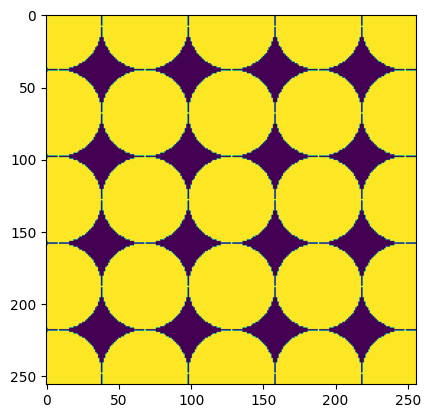

In [ ]:
plt.imshow(Mpred[0,0,:,:].detach().cpu().squeeze(),vmin=0,vmax=1)
plt.imshow(Mpred[0,0,:,:].detach().cpu().squeeze(),vmin=0,vmax=1)

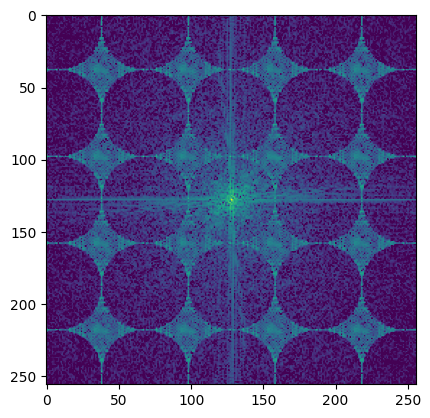

In [ ]:
plt.imshow(torch.log(abs(Ffuse[0,0,:,:])+1e-5).detach().cpu().squeeze(),vmin=0,vmax=10)

In [ ]:
# See the effect of clipping
def clipper(A,vmin,vmax):

  #This function saturates the values below vmin to vmin and so on

  A = torch.clamp(A, min=vmin, max=vmax)
  return A

def rescaler(A,vmin,vmax):

  #This function saturates the values below vmin to vmin and so on
  A = clipper(A,vmin,vmax)
  A = (A-vmin)/(vmax-vmin)
  return A

def inv_rescaler(A,vmin,vmax):

  #This function saturates the values below vmin to vmin and so on

  A = A * (vmax-vmin) + vmin
  return A